## **I’m Something of a Painter Myself- WGAN Implementation**

In [ ]:

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision
import shutil
import torch
import os
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
class PaintingsDataset(Dataset):

    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

    def get_original_item(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return image

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Hyperparameters
batch_size = 6
lr = 2e-4
n_epochs = 100
display_epoch = 10

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # Data augmentation
    #transforms.ElasticTransform(alpha=150.0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torch.utils.data import DataLoader

monet_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/monet_jpg', transform)
photo_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/photo_jpg', transform)

# Initialize data loaders
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

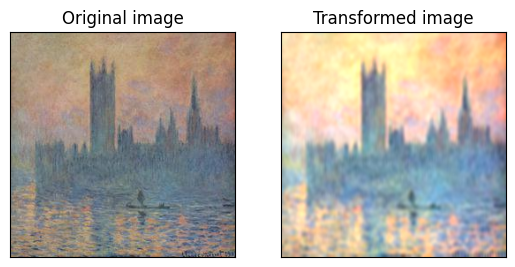

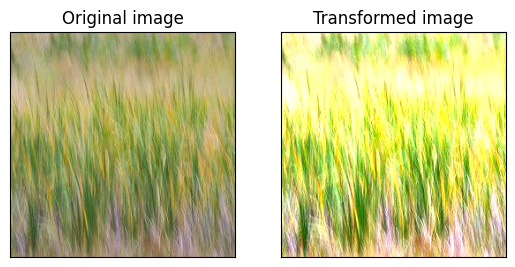

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_dataset_images(n, dataset):
    """
    Show a random image n from dataset with its original format and transformed format
    args:
            n : example image index
            dataset : dataset of interest
    returns:
            plot's with original and transformed image side-by-side
    """
    ex_im_transf = dataset.__getitem__(n)
    ex_im_crude = dataset.get_original_item(n)
    im_transf = np.squeeze(ex_im_transf)
    im_crude = np.squeeze(ex_im_crude)

    f, axarr = plt.subplots(1,2)
    for i in range(2):
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

    axarr[1].imshow(im_transf.permute(1, 2, 0))
    axarr[0].imshow(im_crude)
    axarr[1].set_title("Transformed image")
    axarr[0].set_title("Original image")
    plt.show()

# Visualize data augmentation in both datasets
randn = random.randint(1,298)
visualize_dataset_images(n=randn, dataset=monet_dataset)
visualize_dataset_images(n=randn, dataset=photo_dataset)

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        channels_img = 3
        features_d = 64

        self.model = nn.Sequential(
            # Input : N x 3 x 256 x 256
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Downsampling blocks
            self.create_conv_block(features_d, features_d * 2, 4, 2, 1),
            self.create_conv_block(features_d * 2, features_d * 4, 4, 2, 1),
            self.create_conv_block(features_d * 4, features_d * 8, 4, 2, 1),
            # Upscaling blocks
            self.create_transpose_conv_block(features_d * 8, features_d * 4, 3, 2, 1, 1),
            self.create_transpose_conv_block(features_d * 4, features_d * 2, 3, 2, 1, 1),
            self.create_transpose_conv_block(features_d * 2, features_d, 3, 2, 1, 1),
            # Final convolutional layer
            nn.Conv2d(features_d, 1, kernel_size=3, stride=2, padding=1)
        )

    def create_conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def create_transpose_conv_block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)

## Generator Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()

        channels_img = 3
        features_g = 64

        # Initial convolution layer
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels_img, features_g, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(features_g),
            nn.ReLU(inplace=True)
        )

        # Downsample layers
        self.downsample_blocks = nn.Sequential(
            self.create_downsample_block(features_g, features_g * 2),
            self.create_downsample_block(features_g * 2, features_g * 4)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(features_g * 4) for _ in range(num_residual_blocks)]
        )

        # Upsample layers
        self.upsample_blocks = nn.Sequential(
            self.create_upsample_block(features_g * 4, features_g * 2),
            self.create_upsample_block(features_g * 2, features_g)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(features_g, channels_img, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

    def create_downsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def create_upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

## Residual Network

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

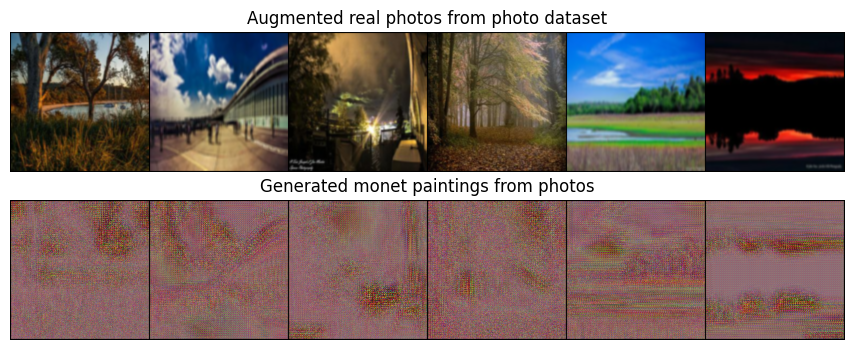

In [ ]:


# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = optim.RMSprop(D.parameters(), lr=lr)

def generate_sample_images(real_X, generator):
    """
    Sample images from batch size n with current generator model parameters
    args:
            images with format (n x 3 x size(image) x size(image))
            generator model
    returns:
            plot's with original and transformed image side-by-side
    """

    generator.eval()


    real_pic = real_X.type(Tensor)
    artificial_pic = generator(real_X).detach()
    ncols = real_X.size(0)
    real_pic_grid = vutils.make_grid(real_pic, nrow=ncols, normalize=True)
    artificial_pic_grid = vutils.make_grid(artificial_pic, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 1, figsize=(20, 4))
    axs[0].imshow(real_pic_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Augmented real photos from photo dataset")
    axs[0].axis('off')
    axs[1].imshow(artificial_pic_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated monet paintings from photos")
    axs[1].axis('off')
    plt.show()
real_X = next(iter(photo_loader))
real_Y = next(iter(photo_loader))
generate_sample_images(real_X.to(device), G)

  9%|▉         | 9/100 [06:01<1:00:53, 40.15s/it]

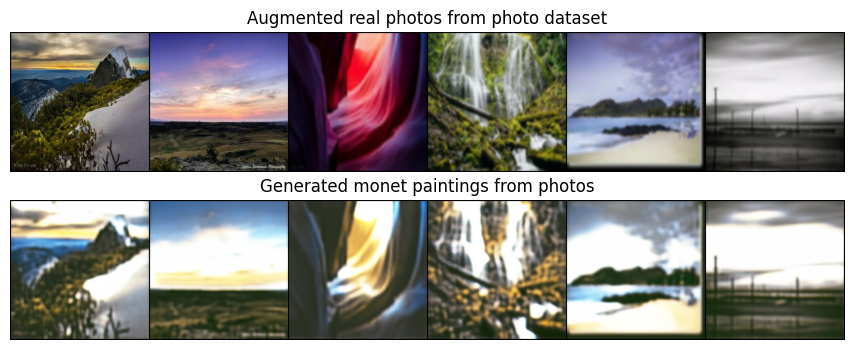

 10%|█         | 10/100 [06:42<1:00:34, 40.38s/it]

Epoch 10/100
Generator loss: 1.2741
Discriminator (Critic) loss: -0.0777


 19%|█▉        | 19/100 [12:43<54:11, 40.15s/it]  

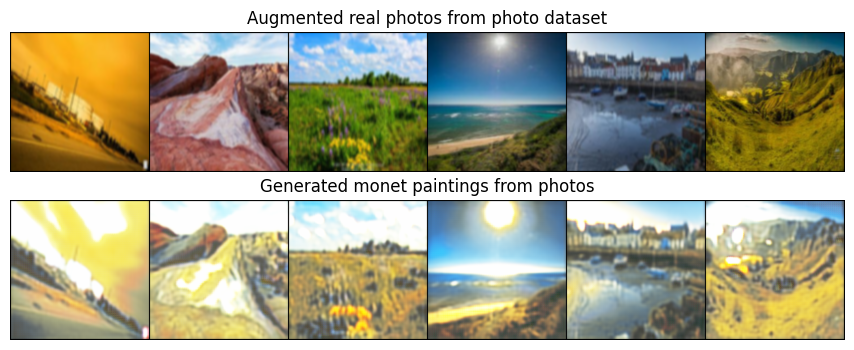

 20%|██        | 20/100 [13:24<53:49, 40.37s/it]

Epoch 20/100
Generator loss: 0.9401
Discriminator (Critic) loss: -0.0030


 29%|██▉       | 29/100 [19:25<47:29, 40.13s/it]

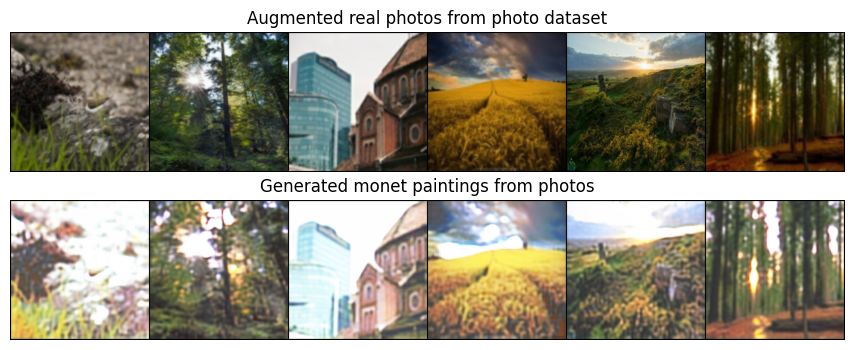

 30%|███       | 30/100 [20:06<47:02, 40.32s/it]

Epoch 30/100
Generator loss: 0.9045
Discriminator (Critic) loss: -0.0293


 39%|███▉      | 39/100 [26:06<40:46, 40.10s/it]

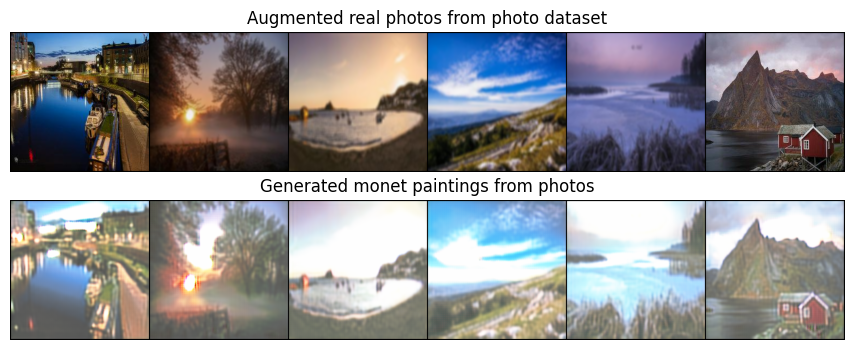

 40%|████      | 40/100 [26:47<40:19, 40.33s/it]

Epoch 40/100
Generator loss: 1.0405
Discriminator (Critic) loss: -0.0912


 49%|████▉     | 49/100 [32:48<34:04, 40.09s/it]

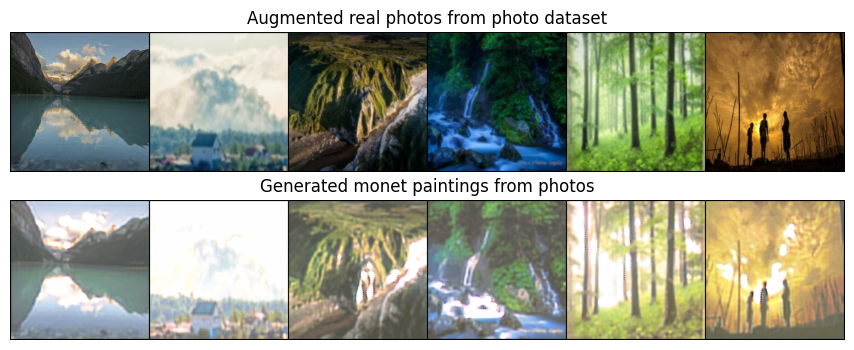

 50%|█████     | 50/100 [33:29<33:35, 40.32s/it]

Epoch 50/100
Generator loss: 0.9646
Discriminator (Critic) loss: -0.0906


 59%|█████▉    | 59/100 [39:29<27:23, 40.09s/it]

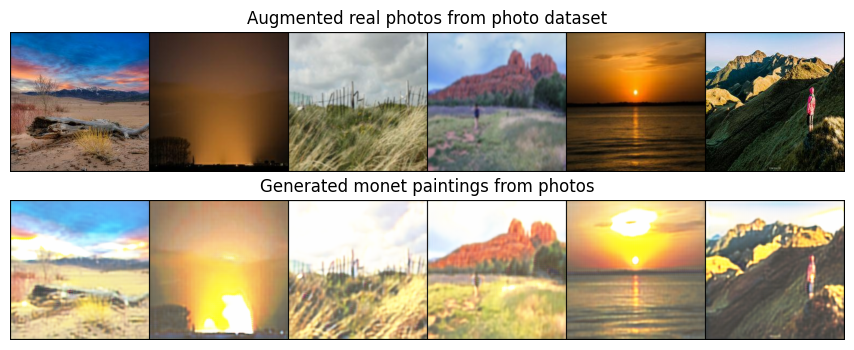

 60%|██████    | 60/100 [40:10<26:52, 40.32s/it]

Epoch 60/100
Generator loss: 0.8844
Discriminator (Critic) loss: -0.0921


 69%|██████▉   | 69/100 [46:11<20:42, 40.08s/it]

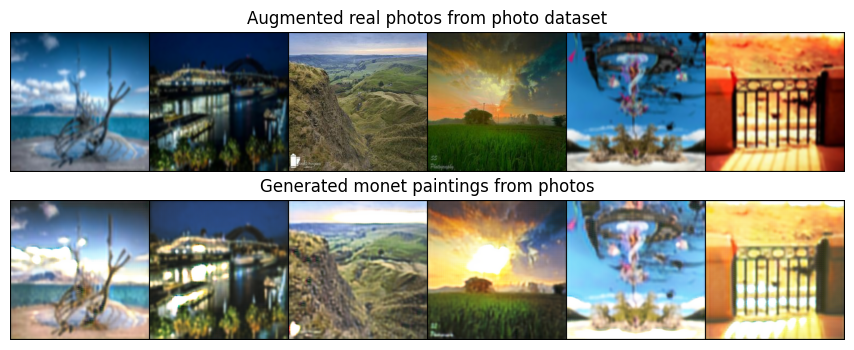

 70%|███████   | 70/100 [46:51<20:08, 40.28s/it]

Epoch 70/100
Generator loss: 0.6191
Discriminator (Critic) loss: -0.0588


 79%|███████▉  | 79/100 [52:52<14:01, 40.07s/it]

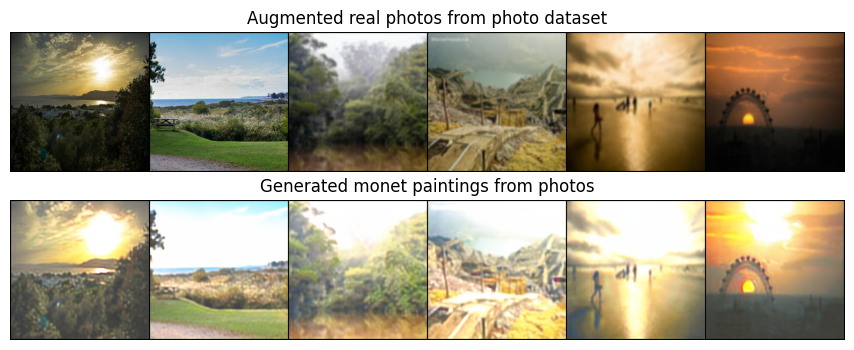

 80%|████████  | 80/100 [53:33<13:25, 40.28s/it]

Epoch 80/100
Generator loss: 1.0892
Discriminator (Critic) loss: -0.0697


 89%|████████▉ | 89/100 [59:33<07:20, 40.07s/it]

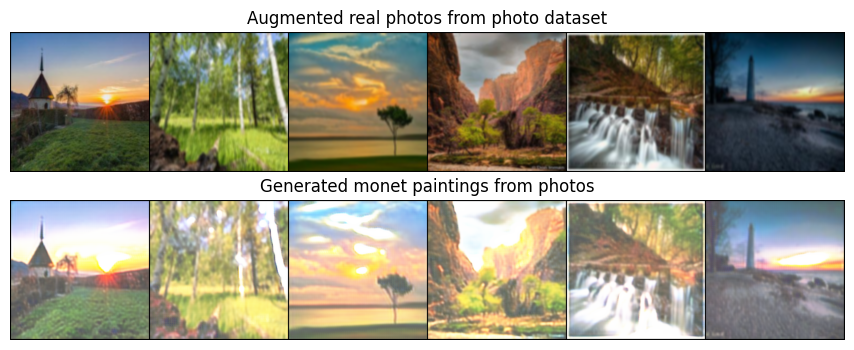

 90%|█████████ | 90/100 [1:00:14<06:43, 40.30s/it]

Epoch 90/100
Generator loss: 0.8501
Discriminator (Critic) loss: -0.0662


 99%|█████████▉| 99/100 [1:06:14<00:40, 40.06s/it]

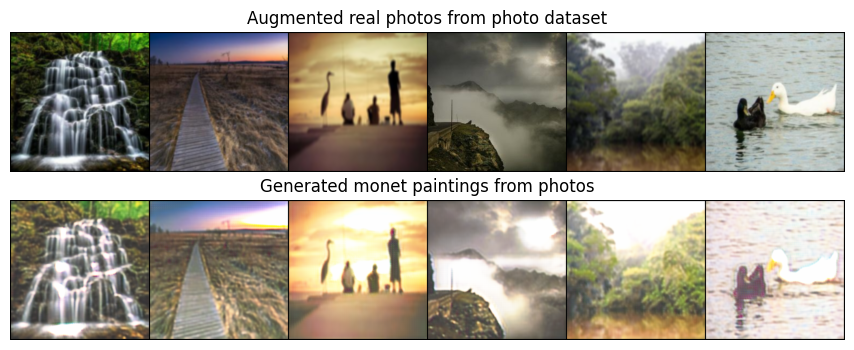

100%|██████████| 100/100 [1:06:55<00:00, 40.16s/it]

Epoch 100/100
Generator loss: 0.5448
Discriminator (Critic) loss: -0.0828


In [ ]:
from tqdm import tqdm
import torch.optim as optim

CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
lambda_identity = 5
identity_loss_function = nn.L1Loss()

for epoch in tqdm(range(n_epochs)):
    for i, (real_photo, real_monet) in enumerate(zip(photo_loader, monet_loader)):
        # Prepare the real and generated data
        real_photo = real_photo.type(Tensor)
        real_monet = real_monet.type(Tensor)

        # Train the Critic - We wish to maximize the difference between the fake and the real images
        for _ in range(CRITIC_ITERATIONS):
            optimizer_D.zero_grad()

            # Generate a batch of images
            artificial_monet = G(real_photo)

            # Critic scores for real and fake images
            critic_real = D(real_monet).reshape(-1)
            critic_fake = D(artificial_monet.detach()).reshape(-1)

            # Calculate the loss for the critic
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            loss_critic.backward(retain_graph=True)
            optimizer_D.step()

            # Weight clipping - to satisfy lipshitz constraint
            for p in D.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train the Generator
        optimizer_G.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        gen_fake = D(artificial_monet).reshape(-1)

        # Calculate G's loss
        loss_G_Wasserstein = -torch.mean(gen_fake)

        # Calculate identity loss
        identity_loss = identity_loss_function(artificial_monet, real_photo)

        # Total generator loss
        loss_G = loss_G_Wasserstein + lambda_identity * identity_loss

        loss_G.backward()
        optimizer_G.step()

    if (epoch + 1) % display_epoch == 0:
        test_real_photo, test_real_monet = next(iter(zip(photo_loader, monet_loader)))
        generate_sample_images(test_real_photo.type(Tensor))
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print(f'Generator loss: {loss_G.item():.4f}')
        print(f'Discriminator (Critic) loss: {loss_critic.item():.4f}')

In [ ]:
# Define the paths to save the weights
generator_weights_path = "generator_epoch_100.pth"
discriminator_weights_path = "discriminator_epoch_100.pth"

# Save the weights of the generator and discriminator
torch.save(G.state_dict(), generator_weights_path)
torch.save(D.state_dict(), discriminator_weights_path)

print(f"Weights saved successfully at epoch 100!")


Weights saved successfully at epoch 100!


In [ ]:
import os
import torch
import torchvision
import shutil

# Create path to save created monet paintings
transformed_save_dir = '../images'
os.makedirs(transformed_save_dir, exist_ok=True)
G.eval()
total_images_saved = 0

try:
    for i, real_photos in enumerate(photo_loader):
        real_photos = real_photos.to(device)

        with torch.no_grad():
            monet_style_imgs = G(real_photos)
        for j, img in enumerate(monet_style_imgs):
            # Denormalize the image for proper saving
            img_to_save = (img + 1) / 2  # Assuming Tanh output, scale from [-1,1] to [0,1]
            save_path = os.path.join(transformed_save_dir, f'monet_painting_{i * batch_size + j}.png')
            torchvision.utils.save_image(img_to_save, save_path)
            total_images_saved += 1

    print(f"Transformed images are saved in {transformed_save_dir}")
    print(f"Total images transformed and saved: {total_images_saved}")

    # Create zip archive of transformed images
    shutil.make_archive("/kaggle/working/images", 'zip', transformed_save_dir)
    print("Images successfully archived")

except Exception as e:
    print(f"An error occurred during image transformation: {e}")

Transformed images are saved in ../images
Total images transformed and saved: 7038
Images successfully archived


In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_images(image_paths, transform=None):
    """
    Load images from paths and apply optional transformation
    """
    images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            if transform:
                img = transform(img)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return torch.stack(images)

def calculate_activations(images, model, device):
    """
    Calculate image activations using pre-trained InceptionV3
    """
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        activations = model(images)
    return activations.cpu().numpy()

def calculate_mifid(real_image_paths, generated_image_paths, batch_size=32, device='cuda'):
    """
    Calculate Modified Fréchet Inception Distance (MiFID)

    Args:
    - real_image_paths (list): Paths to real images
    - generated_image_paths (list): Paths to generated images
    - batch_size (int): Batch size for processing images
    - device (str): Device to run the computation on ('cuda' or 'cpu')

    Returns:
    - float: MiFID score
    """
    # Prepare InceptionV3 model
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = nn.Identity()  # Remove the classification layer
    inception.eval()

    # Define the same transformation as used in training
    transform = transforms.Compose([
        transforms.Resize(int(256 * 1.33)),  # Resize with scaling
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Load and process real images in batches
    real_activations = []
    for i in range(0, len(real_image_paths), batch_size):
        batch_paths = real_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        real_activations.append(calculate_activations(batch_images, inception, device))
    real_activations = np.concatenate(real_activations, axis=0)

    # Load and process generated images in batches
    generated_activations = []
    for i in range(0, len(generated_image_paths), batch_size):
        batch_paths = generated_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        generated_activations.append(calculate_activations(batch_images, inception, device))
    generated_activations = np.concatenate(generated_activations, axis=0)

    # Calculate mean and covariance
    real_mu = np.mean(real_activations, axis=0)
    generated_mu = np.mean(generated_activations, axis=0)

    real_sigma = np.cov(real_activations, rowvar=False)
    generated_sigma = np.cov(generated_activations, rowvar=False)

    # Compute FID
    diff = real_mu - generated_mu
    covmean, _ = scipy.linalg.sqrtm(real_sigma.dot(generated_sigma), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(real_sigma + generated_sigma - 2 * covmean)

    # Compute scaling factor for MiFID
    scale = math.sqrt(len(real_image_paths) / len(generated_image_paths))
    mifid = fid * scale

    return fid, mifid

# Define paths for real and generated images
real_image_paths = [os.path.join('/kaggle/input/gan-getting-started/photo_jpg', f)
                    for f in os.listdir('/kaggle/input/gan-getting-started/photo_jpg') if f.endswith(('.jpg', '.jpeg', '.png'))]

generated_image_paths = [os.path.join('../images', f)
                         for f in os.listdir('../images') if f.endswith(('.jpg', '.jpeg', '.png'))]

# Calculate scores
fid_score, mifid_score = calculate_mifid(real_image_paths, generated_image_paths, batch_size=32, device=device)
print(f"FID Score: {fid_score}")
print(f"MiFID Score: {mifid_score}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 193MB/s]  


FID Score: 36.984121953717064
MiFID Score: 36.984121953717064
